# Day089
## 訓練神經網路的細節與技巧 - 撰寫自己的 Loss function
在 Keras 中，除了使用官方提供的 Loss function 外，亦可以自行定義/修改 loss function
- 所定義的函數:
    - 最內層函式的參數輸入須根據 output tensor 而定，舉例來來說，在分類模型中需要有 y_true, y_pred
    - 需要使用 tensor operations – 即在 tensor 上運算而非在 numpy array 上進行運算
    - 回傳的結果是一個 tensor
    
### In Keras:
> import keras.backend as K<br>
def dice_coef(y_true, y_pred, smooth):<br>
&emsp;y_pred = y_pred >= 0.5<br>
&emsp;y_true_f = K.flatten(y_true)<br>
&emsp;y_pred_f = K.flatten(y_pred)<br>
&emsp;intersection = K.sum(y_true_f * y_pred_f)<br>
<br>
&emsp;return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

- 皆須使用 tensor operations
- 上方為最內層的函式 – 在分類問題中，只能有y_true 與 y_pred，其他調控參數應置於外層函式如下:

> def dice_loss(smooth):<br>
&emsp;def dice(y_true, y_pred):<br>
&emsp;&emsp;return - dice_coef(y_true, y_pred, smooth)<br>
&emsp;return dice

- 輸出為 Tensor

## 範例

In [3]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Preprocessing
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import Input, Dense, BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [5]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### [來自Facebook Research物體偵測的最新進展：Focal Loss for Dense Object Detection](https://data-sci.info/2017/08/10/%E4%BE%86%E8%87%AAfacebook-research%E7%89%A9%E9%AB%94%E5%81%B5%E6%B8%AC%E7%9A%84%E6%9C%80%E6%96%B0%E9%80%B2%E5%B1%95%EF%BC%9Afocal-loss-dense-object-detection-2/)

In [14]:
import tensorflow as tf
import keras.backend as K

def focal_loss(gamma = 2., alpha = 4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """
        Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [15]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss=focal_loss(), metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
__________

Epoch 46/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.1279 - acc: 0.9856 - val_loss: 6.1786 - val_acc: 0.4717
Epoch 47/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.1177 - acc: 0.9870 - val_loss: 6.3970 - val_acc: 0.4717
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1042 - acc: 0.9904 - val_loss: 6.2510 - val_acc: 0.4814
Epoch 49/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.0945 - acc: 0.9911 - val_loss: 6.3064 - val_acc: 0.4816
Epoch 50/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.0878 - acc: 0.9925 - val_loss: 6.3523 - val_acc: 0.4832


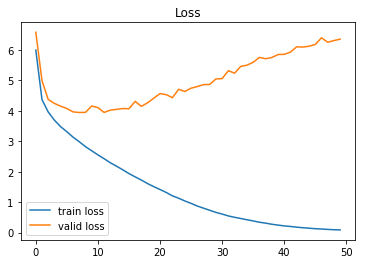

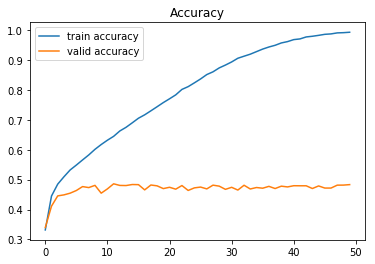

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [31]:
import tensorflow as tf
import keras.backend as K

"""
TO DO:
Write your combined loss
"""
def combined_loss(ce_weight, gamma = 2., alpha = 4.):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def combine(y_true, y_pred):
        """
        Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        fl_fix = tf.reduce_mean(reduced_fl)
        
        combine_loss = tf.add(tf.multiply(ce, ce_weight), tf.multiply(tf.subtract(1., ce_weight), fl_fix))
        return combine_loss
    return combine    
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [32]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """
    TO DO:
    Compile your model with customized loss
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_75 (Batc (None, 128) 

50000/50000 [==============================] - 2s 38us/step - loss: 0.0917 - acc: 0.9922 - val_loss: 6.4058 - val_acc: 0.4770
Epoch 50/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.0837 - acc: 0.9936 - val_loss: 6.4055 - val_acc: 0.4833
Numbers of exp: 1, ce_weight: 0.30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256) 

Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.1464 - acc: 0.9747 - val_loss: 4.1384 - val_acc: 0.4830
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.1352 - acc: 0.9782 - val_loss: 4.2046 - val_acc: 0.4797
Epoch 50/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.1252 - acc: 0.9801 - val_loss: 4.2243 - val_acc: 0.4814
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_79 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)  

50000/50000 [==============================] - 2s 38us/step - loss: 0.2336 - acc: 0.9359 - val_loss: 2.7569 - val_acc: 0.4752
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.2182 - acc: 0.9411 - val_loss: 2.7659 - val_acc: 0.4842
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.2024 - acc: 0.9467 - val_loss: 2.8069 - val_acc: 0.4847
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.1902 - acc: 0.9507 - val_loss: 2.8403 - val_acc: 0.4765
Epoch 50/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.1766 - acc: 0.9543 - val_loss: 2.8515 - val_acc: 0.4798
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)  

Epoch 45/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.3307 - acc: 0.8480 - val_loss: 1.4897 - val_acc: 0.4838
Epoch 46/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.3183 - acc: 0.8527 - val_loss: 1.5163 - val_acc: 0.4788
Epoch 47/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.3053 - acc: 0.8601 - val_loss: 1.5275 - val_acc: 0.4843
Epoch 48/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.2900 - acc: 0.8679 - val_loss: 1.5280 - val_acc: 0.4764
Epoch 49/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.2786 - acc: 0.8742 - val_loss: 1.5462 - val_acc: 0.4822
Epoch 50/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.2662 - acc: 0.8810 - val_loss: 1.5680 - val_acc: 0.4744
Numbers of exp: 4, ce_weight: 1.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input

50000/50000 [==============================] - 2s 37us/step - loss: 0.1413 - acc: 0.5108 - val_loss: 0.1593 - val_acc: 0.4456
Epoch 44/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.1408 - acc: 0.5125 - val_loss: 0.1589 - val_acc: 0.4471
Epoch 45/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.1402 - acc: 0.5152 - val_loss: 0.1587 - val_acc: 0.4496
Epoch 46/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.1395 - acc: 0.5162 - val_loss: 0.1584 - val_acc: 0.4490
Epoch 47/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.1389 - acc: 0.5203 - val_loss: 0.1582 - val_acc: 0.4494
Epoch 48/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.1385 - acc: 0.5212 - val_loss: 0.1581 - val_acc: 0.4496
Epoch 49/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.1379 - acc: 0.5224 - val_loss: 0.1576 - val_acc: 0.4516
Epoch 50/50
50000/50000 [=====================

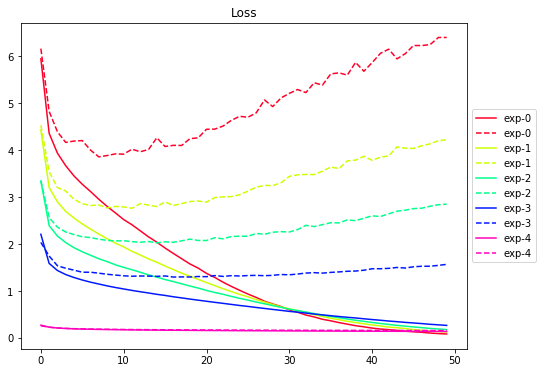

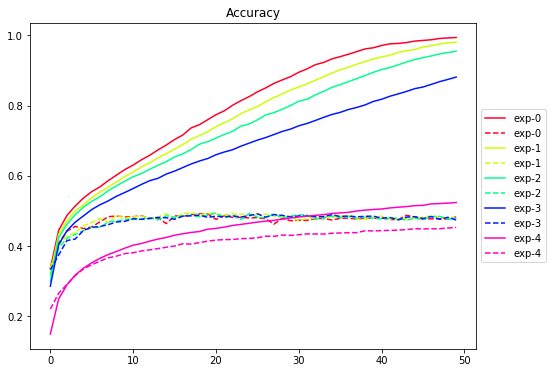

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()